### Get lagged data

According to the *Interim Estimates of Vaccine Effectiveness of BNT162b2 and mRNA-1273 COVID-19 Vaccines in Preventing SARS-CoV-2 Infection Among Health Care Personnel, First Responders, and Other Essential and Frontline Workers — Eight U.S. Locations, December 2020–March 2021* published by CDC, the effectiveness of vaccines has around 14 days lag. Thus, we will add two column **vaccine lag-7** and **vaccine lag-14** for our analysis.

In [1]:
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn import svm

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.columns

Index(['Unnamed: 0', 'state', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'stay_at_home',
       'mask_mandate', 'business_open', 'people_fully_vaccinated_per_hundred',
       'daily_vaccinations_per_million', 'submission_date', 'state_abbr',
       'new_case', 'new_case_ma7', 'new_death', 'new_death_ma7',
       'population_density', 'new_death_growth_rate', 'new_case_growth_rate'],
      dtype='object')

In [4]:
min(data["date"])

'2021-01-01'

In [5]:
max(data["date"])

'2021-04-20'

In [4]:
new_data = pd.DataFrame()
for state in data["state"].unique():
    s = data[data["state"] == state]
    s["people_fully_vaccinated_per_hundred_lag7"] = s["people_fully_vaccinated_per_hundred"].shift(7)
    s["people_fully_vaccinated_per_hundred_lag14"] = s["people_fully_vaccinated_per_hundred"].shift(14)
    s["daily_vaccinations_per_million_lag7"] = s["daily_vaccinations_per_million"].shift(7)
    s["daily_vaccinations_per_million_lag14"] = s["daily_vaccinations_per_million"].shift(14)
    new_data = new_data.append(s)

ipykernel_launcher:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:7: SettingWithCopyWarning: 
A value is trying to be

In [5]:
new_data = new_data.replace("no value", None)

In [6]:
new_data["retail_and_recreation_percent_change_from_baseline"] = new_data["retail_and_recreation_percent_change_from_baseline"] / 100
new_data["grocery_and_pharmacy_percent_change_from_baseline"] = new_data["grocery_and_pharmacy_percent_change_from_baseline"] / 100
new_data["parks_percent_change_from_baseline"] = new_data["parks_percent_change_from_baseline"].astype(float) / 100
new_data["transit_stations_percent_change_from_baseline"] = new_data["transit_stations_percent_change_from_baseline"] / 100
new_data["workplaces_percent_change_from_baseline"] = new_data["workplaces_percent_change_from_baseline"] / 100
new_data["residential_percent_change_from_baseline"] = new_data["residential_percent_change_from_baseline"] / 100

In [7]:
new_data.describe()

Unnamed: 0  retail_and_recreation_percent_change_from_baseline  \
count  5610.000000                                        5610.000000    
mean   2804.500000                                          -0.158699    
std    1619.611836                                           0.135992    
min       0.000000                                          -0.790000    
25%    1402.250000                                          -0.230000    
50%    2804.500000                                          -0.160000    
75%    4206.750000                                          -0.070000    
max    5609.000000                                           0.200000    

       grocery_and_pharmacy_percent_change_from_baseline  \
count                                        5610.000000   
mean                                           -0.071148   
std                                             0.098113   
min                                            -0.660000   
25%                                            -0.120000   
50%                                            -0.070000   
75%                                            -0.010000   
max                                             0.330000   

       parks_percent_change_from_baseline  \
count                         5610.000000   
mean                             0.048365   
std                              0.380531   
min                             -0.760000   
25%                             -0.210000   
50%                             -0.040000   
75%                              0.220000   
max                              2.570000   

       transit_stations_percent_change_from_baseline  \
count                                    5610.000000   
mean                                       -0.246549   
std                                         0.199005   
min                                        -0.870000   
25%                                        -0.390000   
50%                                        -0.250000   
75%                                        -0.110000   
max                                         0.440000   

       workplaces_percent_change_from_baseline  \
count                              5610.000000   
mean                                 -0.256032   
std                                   0.122659   
min                                  -0.860000   
25%                                  -0.330000   
50%                                  -0.250000   
75%                                  -0.170000   
max                                   0.000000   

       residential_percent_change_from_baseline  stay_at_home  mask_mandate  \
count                               5610.000000   5610.000000   5610.000000   
mean                                   0.085207      0.019608      0.693761   
std                                    0.049501      0.138661      0.460971   
min                                   -0.040000      0.000000      0.000000   
25%                                    0.050000      0.000000      0.000000   
50%                                    0.080000      0.000000      1.000000   
75%                                    0.110000      0.000000      1.000000   
max                                    0.360000      1.000000      1.000000   

       business_open  ...  new_case_ma7    new_death  new_death_ma7  \
count    5610.000000  ...   5610.000000  5610.000000    5610.000000   
mean        0.349376  ...   2043.947339    35.526025      36.792819   
std         0.497314  ...   3571.035181    69.453539      61.996979   
min         0.000000  ...     38.571429  -174.000000     -18.000000   
25%         0.000000  ...    328.821429     2.000000       5.142857   
50%         0.000000  ...    924.928571    11.000000      15.285714   
75%         1.000000  ...   2450.071429    39.000000      41.678571   
max         2.000000  ...  42687.571429   764.000000     565.285714   

       population_density  new_death_growth_rate  new_case_growth_rate  \
count       

In [8]:
import matplotlib.pyplot as plt

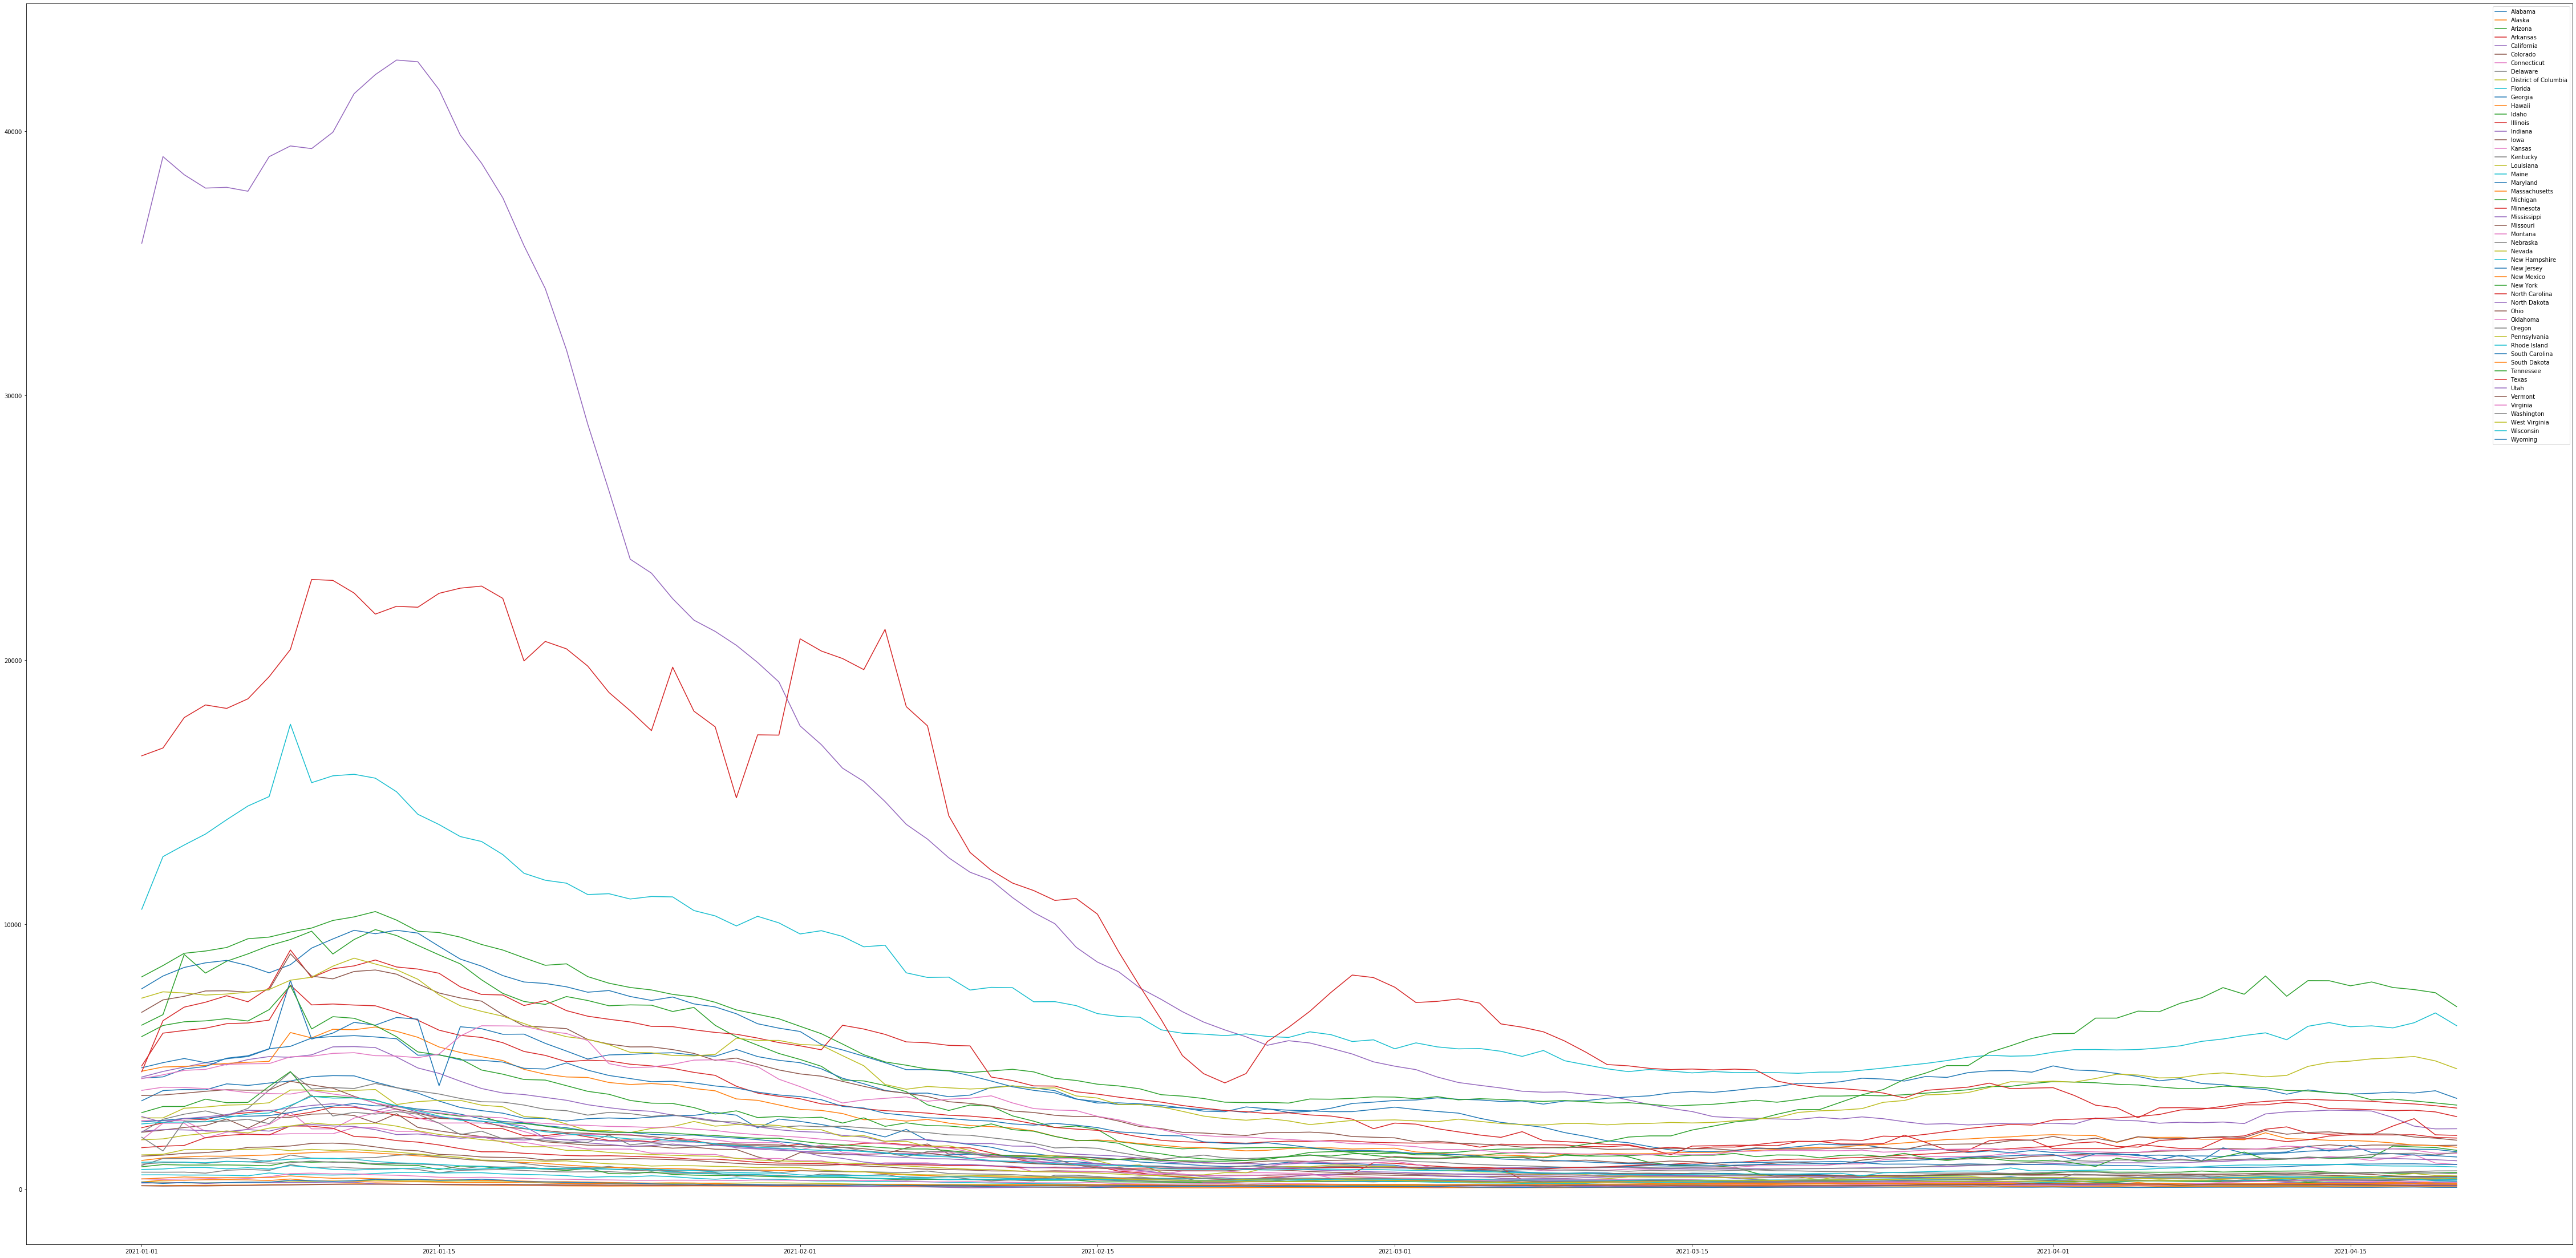

In [11]:
fig= plt.figure(figsize=(80,40))

for state in new_data["state"].unique():
    sub = new_data[new_data["state"] == state]

    x = pd.to_datetime(sub["date"])
    y = sub["new_case_ma7"]

    plt.plot(x, y, label = state)

plt.legend()

plt.show()

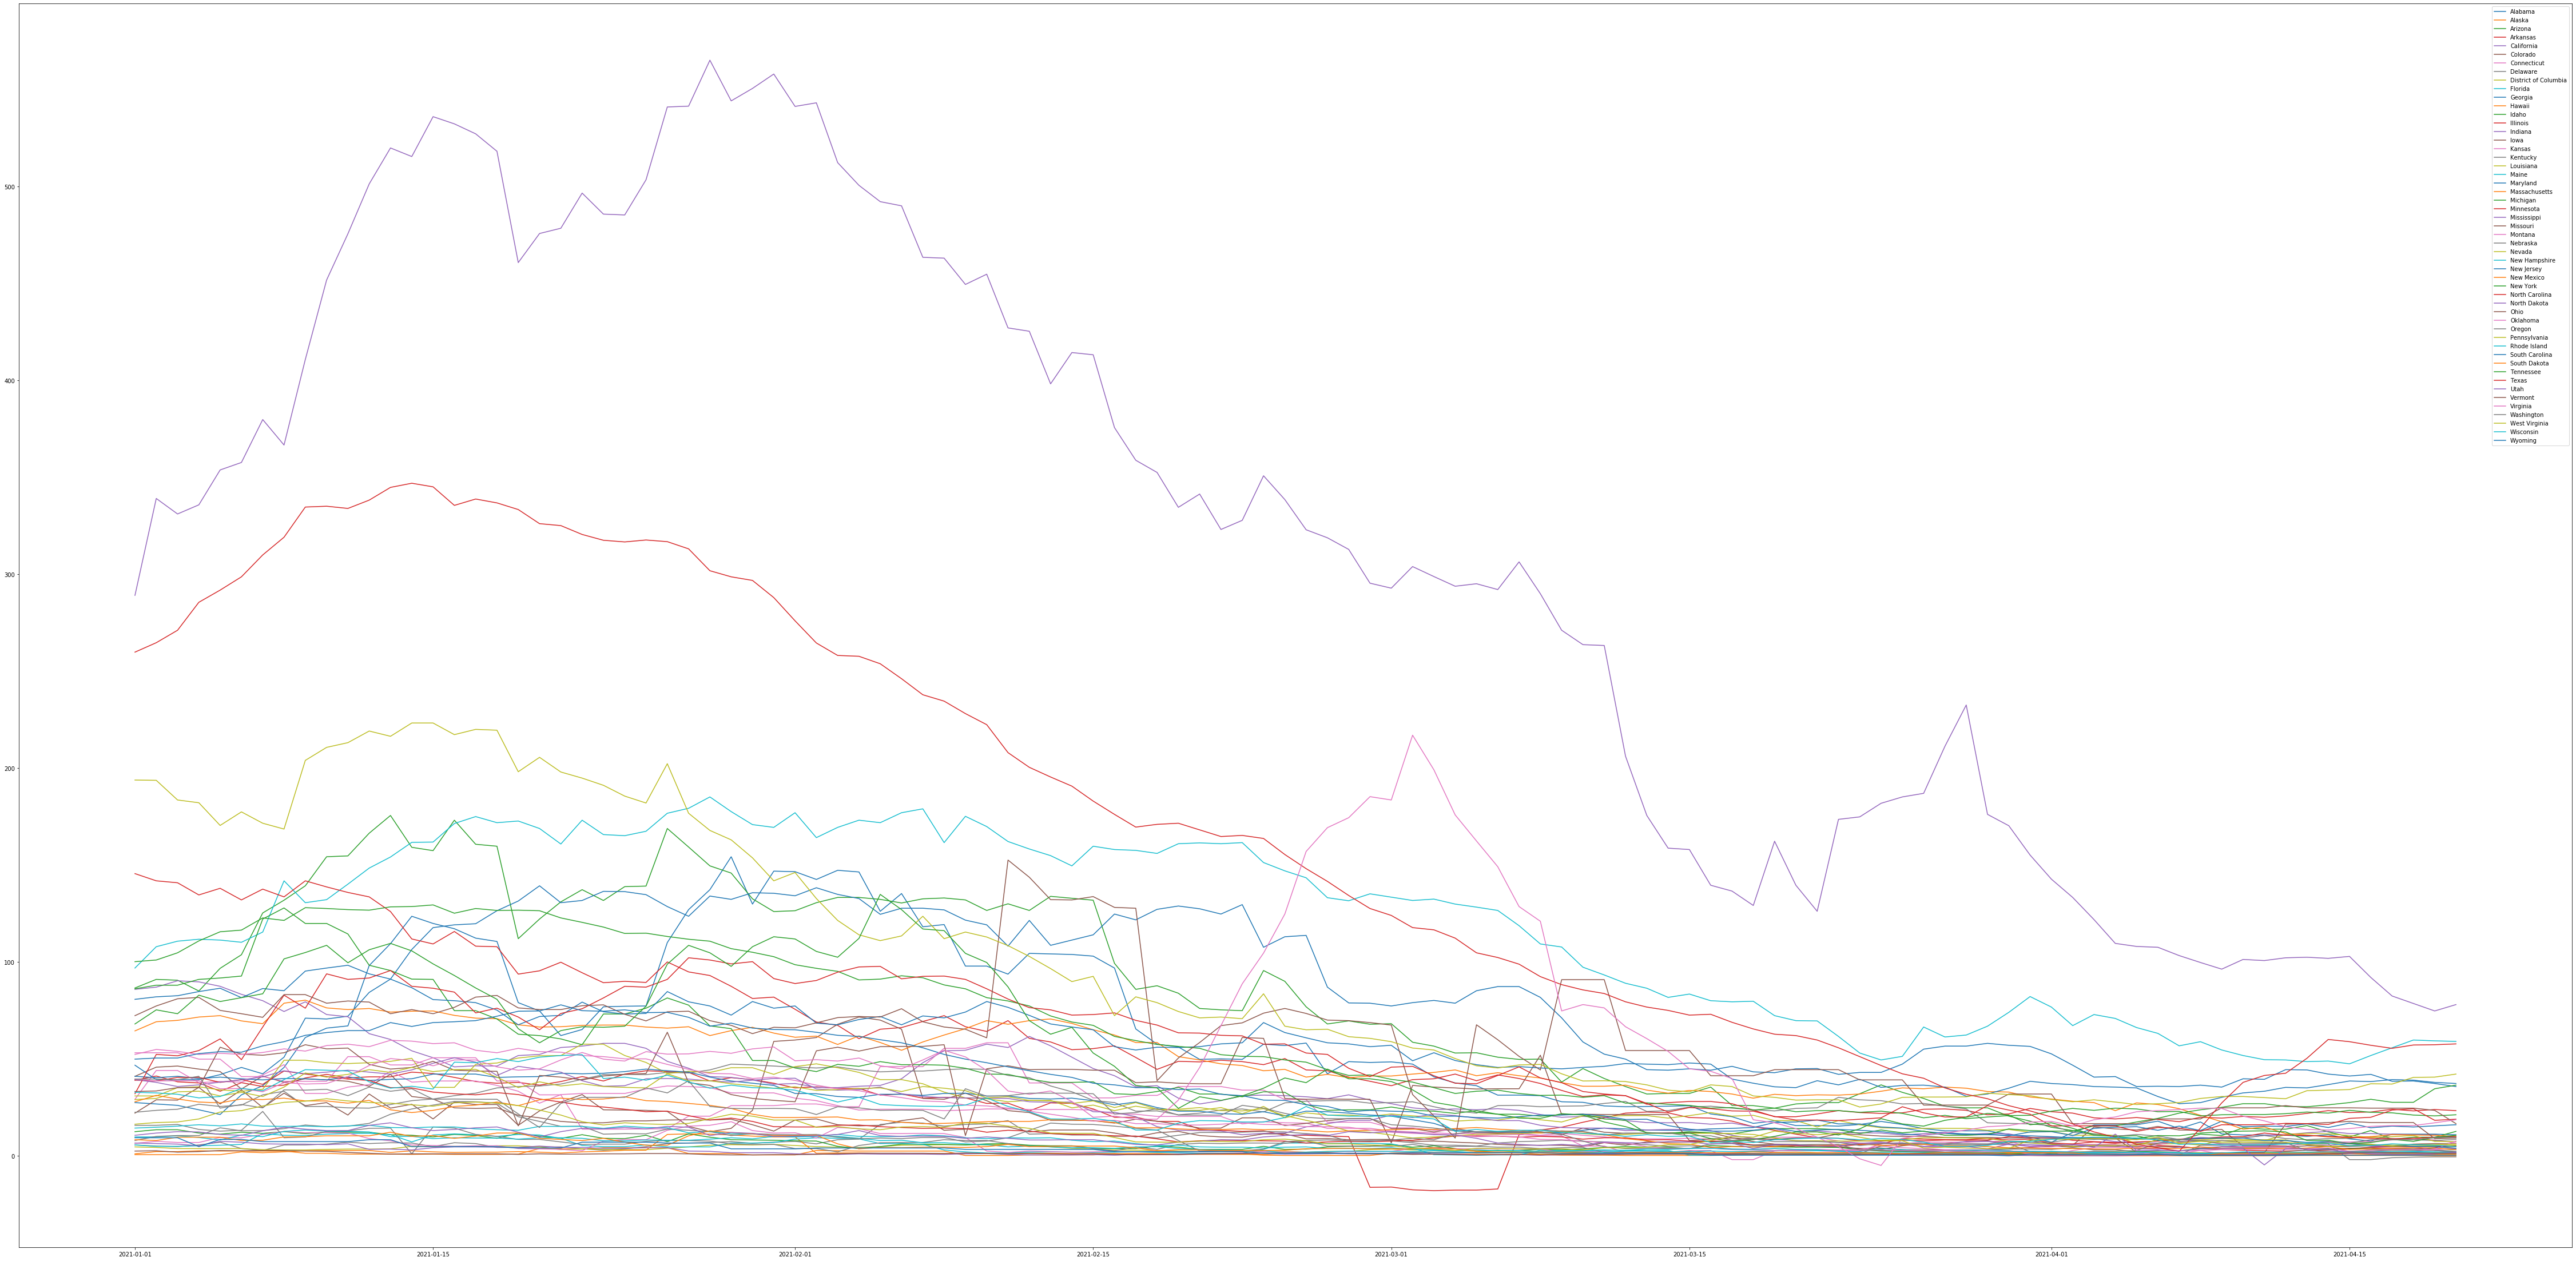

In [12]:
fig= plt.figure(figsize=(80,40))

for state in new_data["state"].unique():
    sub = new_data[new_data["state"] == state]

    x = pd.to_datetime(sub["date"])
    y = sub["new_death_ma7"]

    plt.plot(x, y, label = state)

plt.legend()

plt.show()

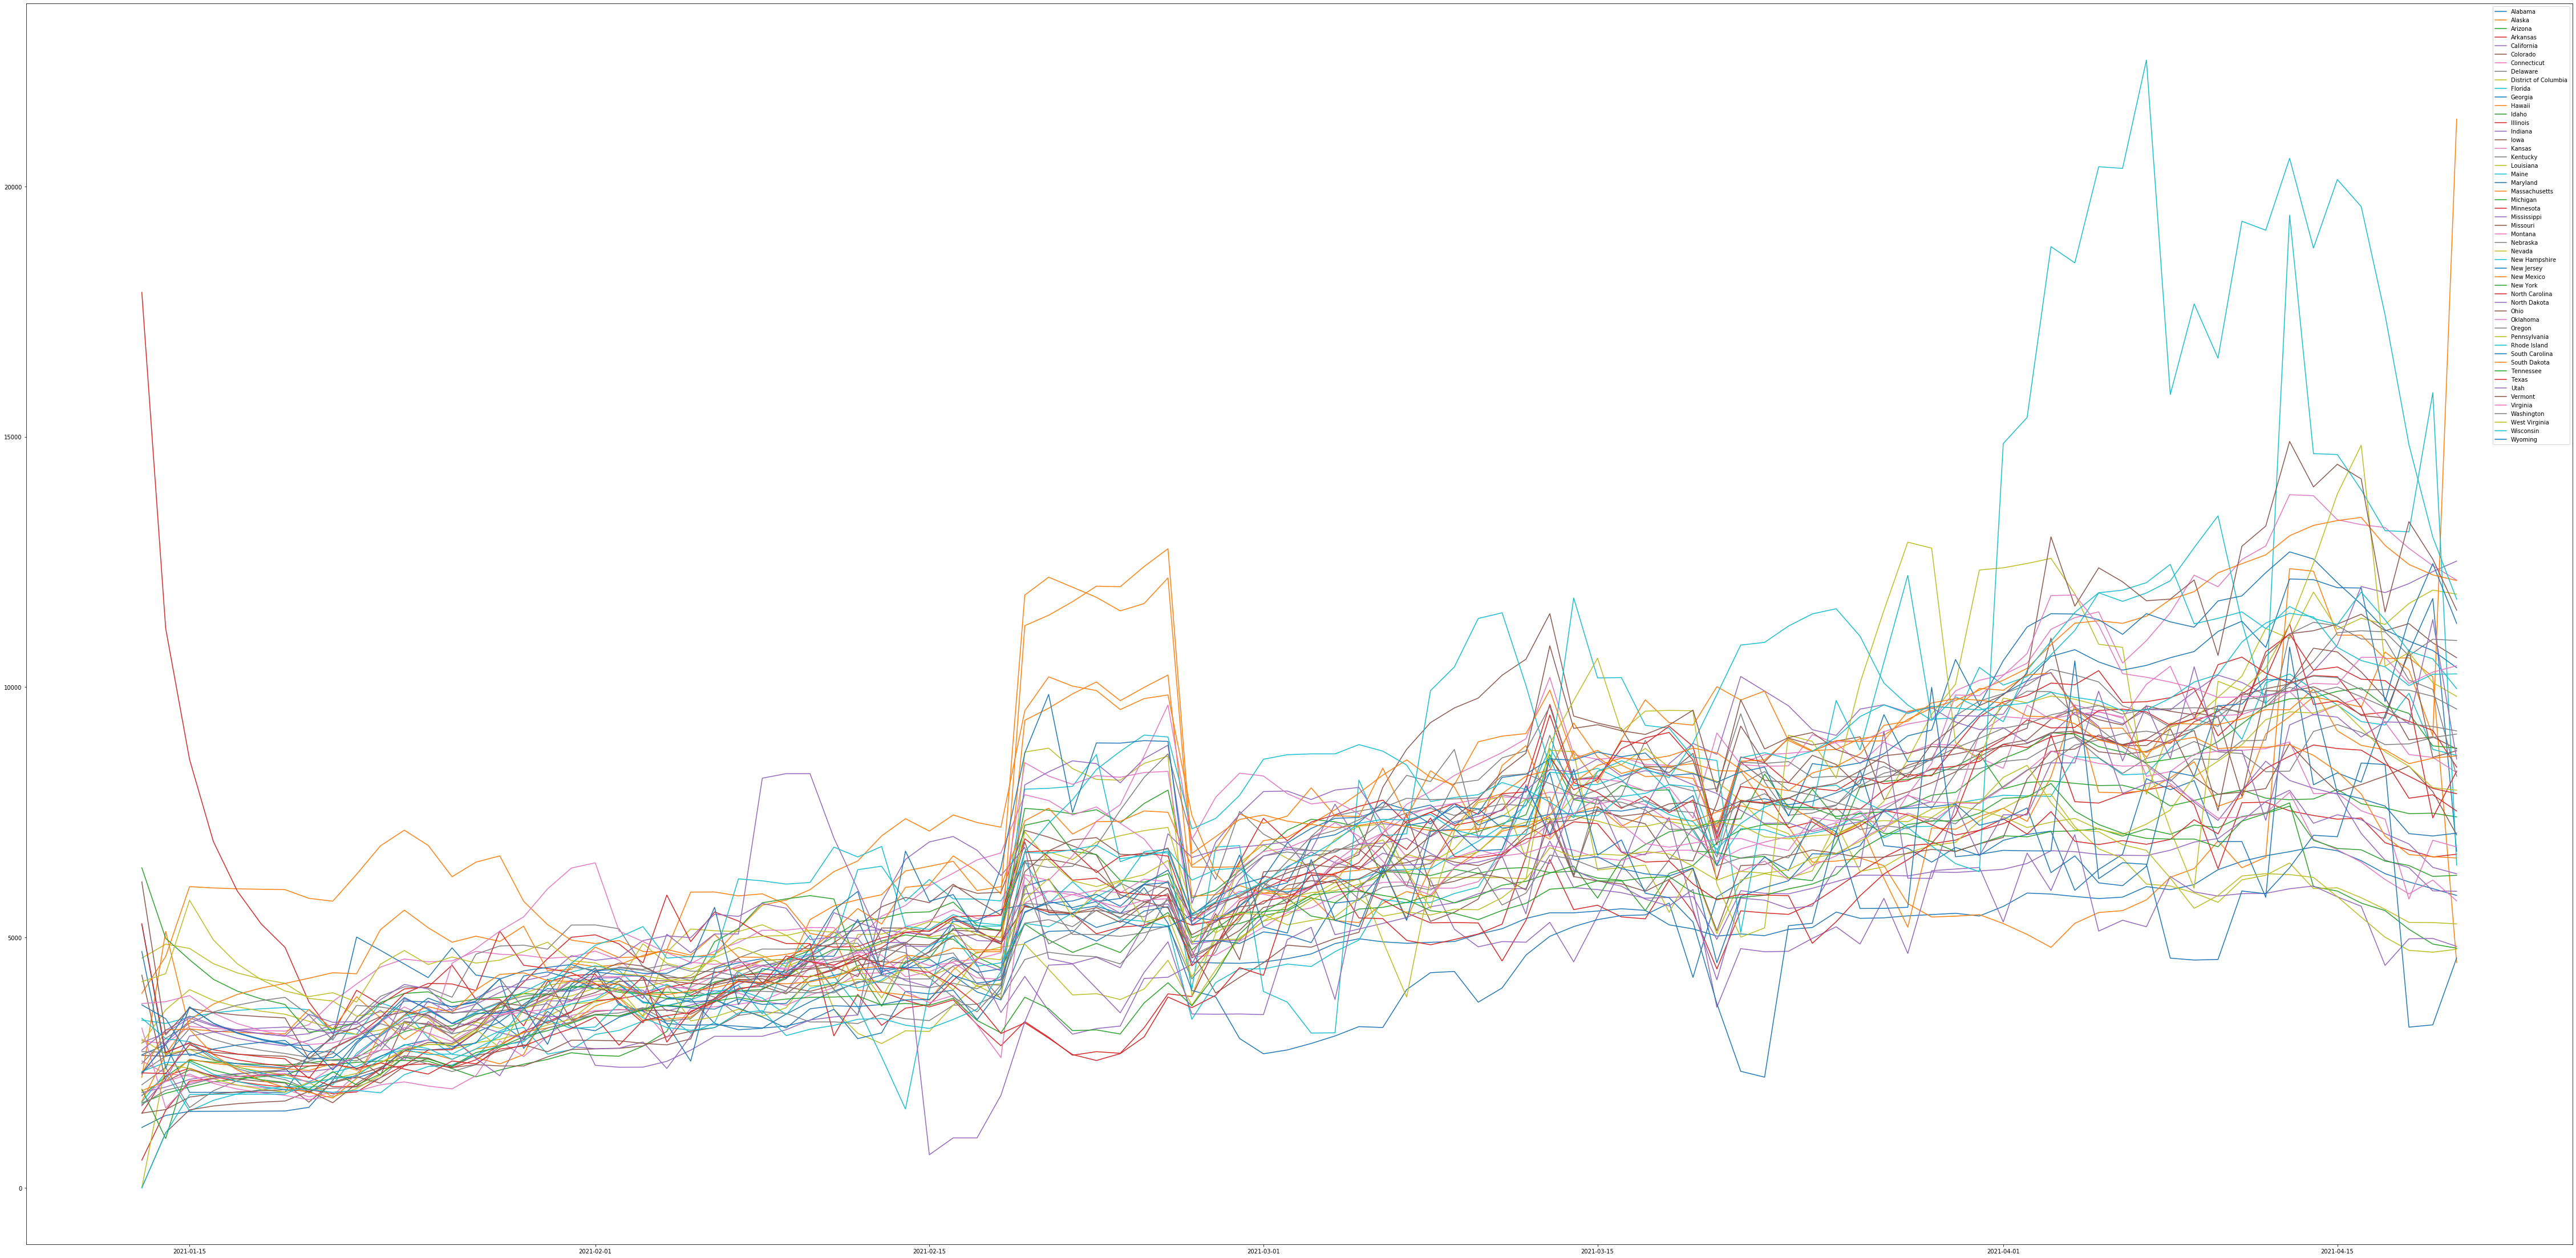

In [13]:
fig= plt.figure(figsize=(80,40))

for state in new_data["state"].unique():
    sub = new_data[new_data["state"] == state]

    x = pd.to_datetime(sub["date"])
    y = sub["daily_vaccinations_per_million"]

    plt.plot(x, y, label = state)

plt.legend()

plt.show()

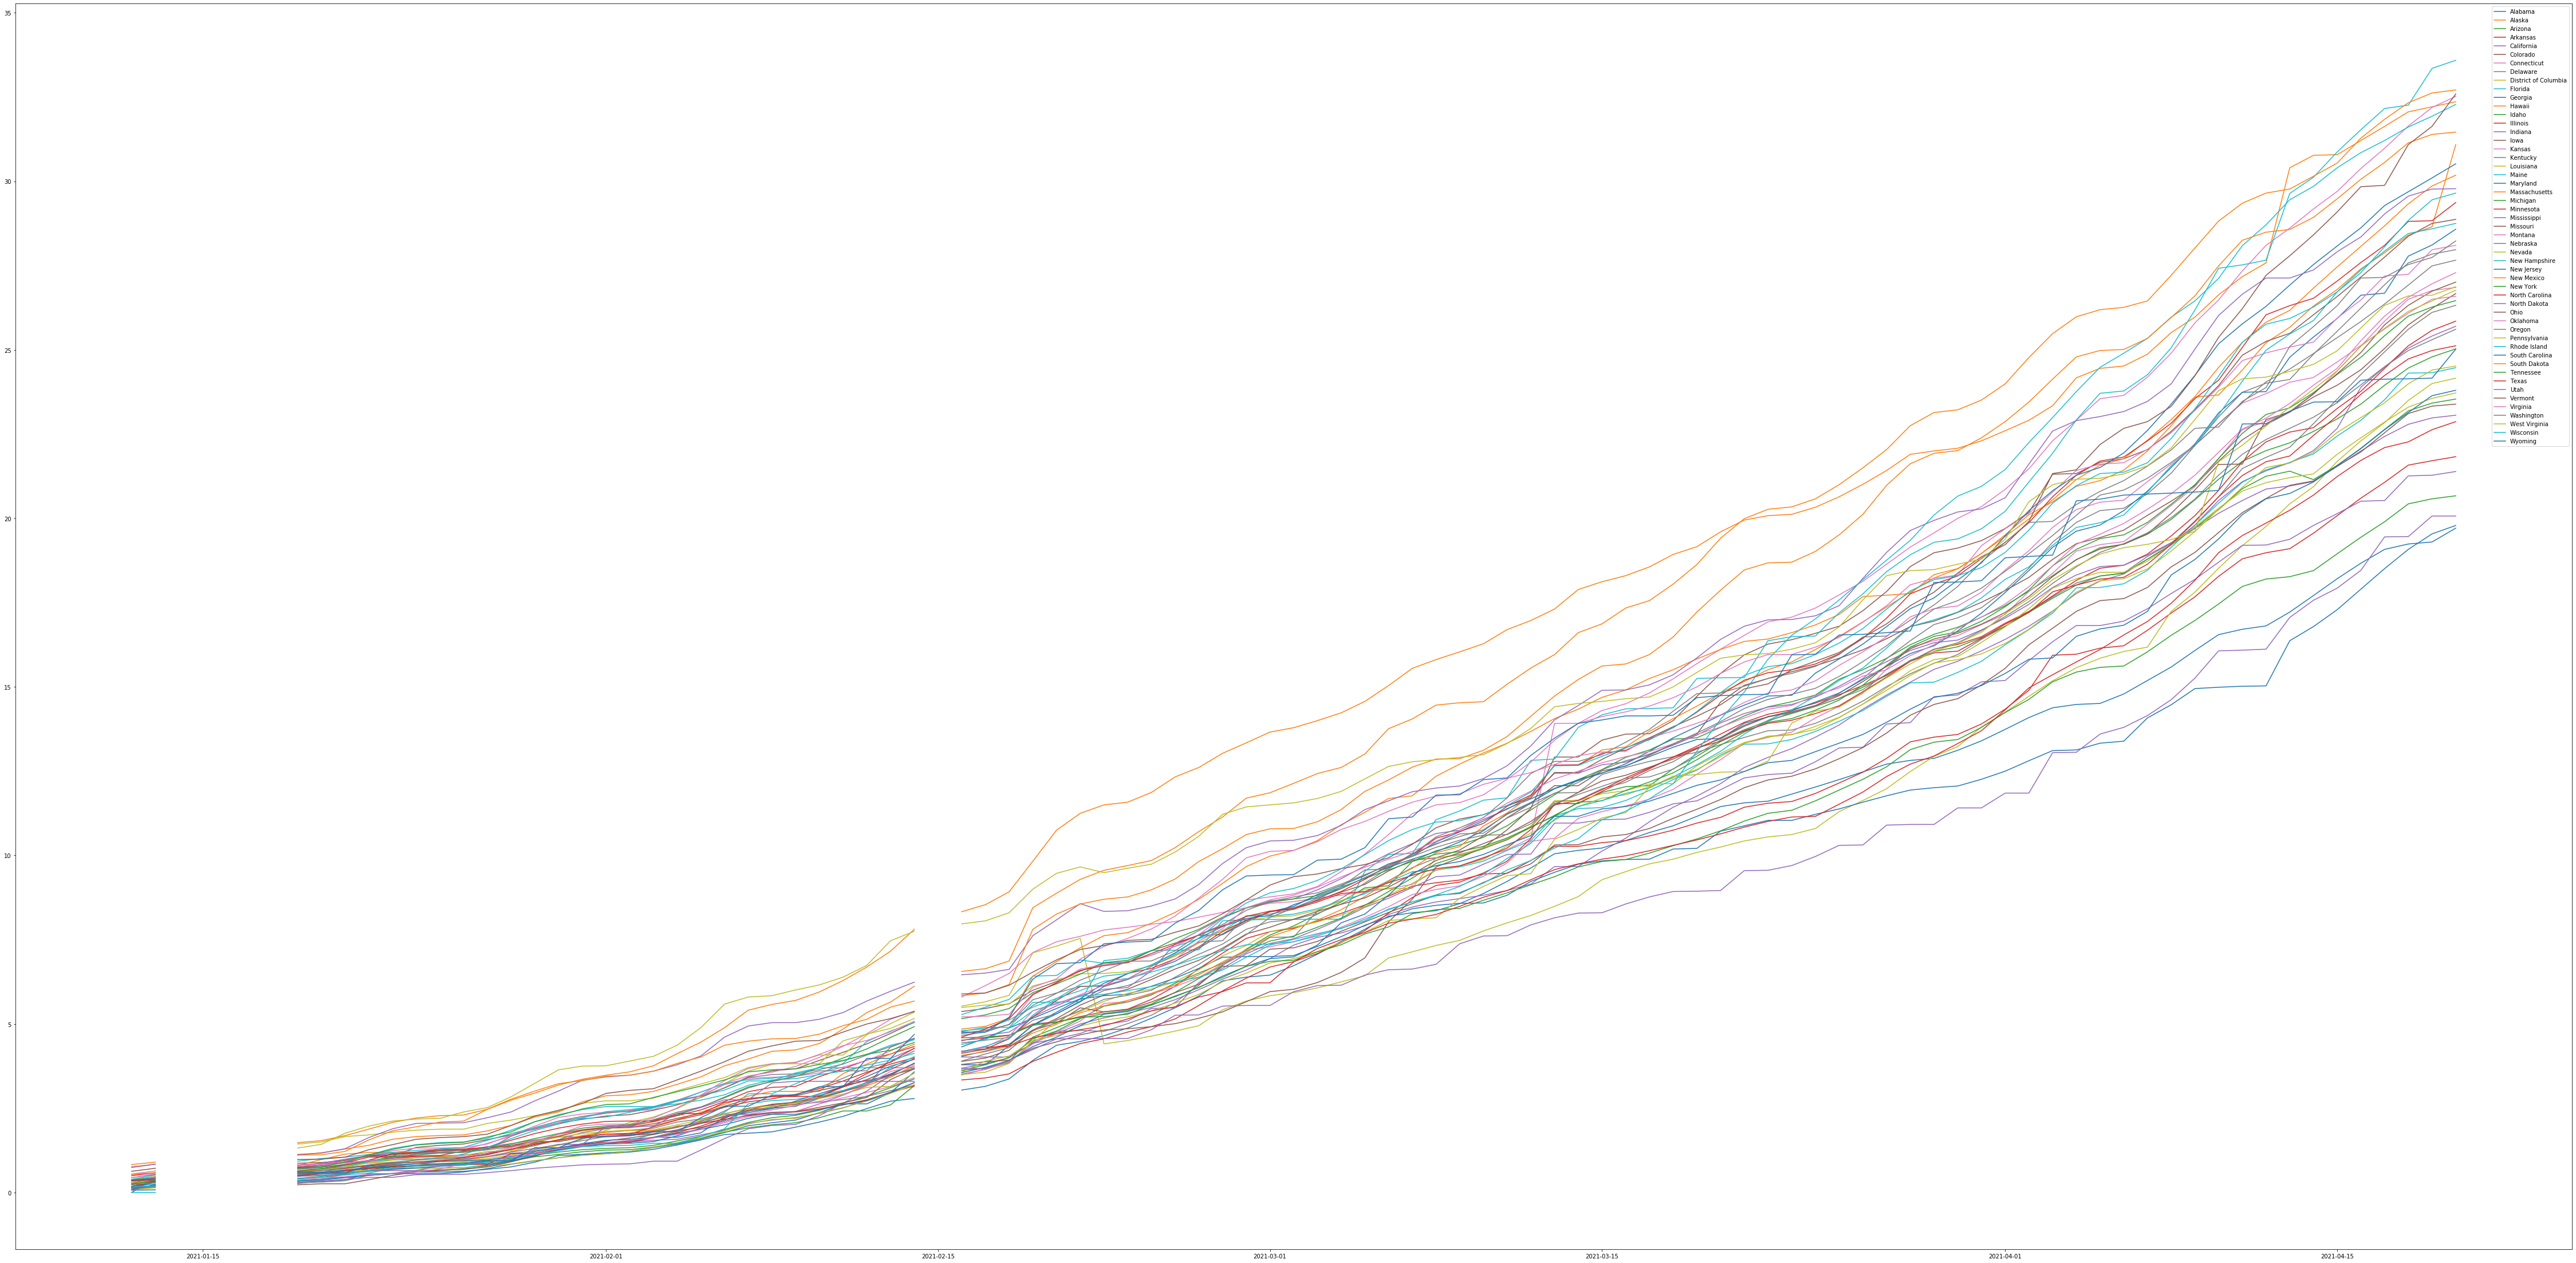

In [14]:
fig= plt.figure(figsize=(80,40))

for state in new_data["state"].unique():
    sub = new_data[new_data["state"] == state]

    x = pd.to_datetime(sub["date"])
    y = sub["people_fully_vaccinated_per_hundred"]

    plt.plot(x, y, label = state)

plt.legend()

plt.show()

In [9]:
new_data = pd.concat([new_data, pd.get_dummies(new_data["business_open"], prefix="business_open")], axis=1)

In [10]:
new_data.columns

Index(['Unnamed: 0', 'state', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'stay_at_home',
       'mask_mandate', 'business_open', 'people_fully_vaccinated_per_hundred',
       'daily_vaccinations_per_million', 'submission_date', 'state_abbr',
       'new_case', 'new_case_ma7', 'new_death', 'new_death_ma7',
       'population_density', 'new_death_growth_rate', 'new_case_growth_rate',
       'people_fully_vaccinated_per_hundred_lag7',
       'people_fully_vaccinated_per_hundred_lag14',
       'daily_vaccinations_per_million_lag7',
       'daily_vaccinations_per_million_lag14', 'business_open_0',
       'business_open_1', 'business_open_2'],
      dtype='object')

In [17]:
len(new_data)

5610

In [11]:
data_without_na = new_data.dropna()

In [12]:
len(data_without_na)

3845

In [20]:
# columns = ['retail_and_recreation_percent_change_from_baseline',
#        'grocery_and_pharmacy_percent_change_from_baseline',
#        'parks_percent_change_from_baseline',
#        'transit_stations_percent_change_from_baseline',
#        'workplaces_percent_change_from_baseline',
#        'residential_percent_change_from_baseline', 'stay_at_home',
#        'mask_mandate', 'people_fully_vaccinated_per_hundred',
#        'daily_vaccinations_per_million',
#        'population_density',
#        'people_fully_vaccinated_per_hundred_lag7',
#        'people_fully_vaccinated_per_hundred_lag14',
#        'daily_vaccinations_per_million_lag7',
#        'daily_vaccinations_per_million_lag14', 'business_open_0',
#        'business_open_1', 'business_open_2']

## Vaccine only analysis

### Normalize

In [13]:
Y1 = data_without_na["new_death_growth_rate"].to_numpy()
Y2 = data_without_na["new_case_growth_rate"].to_numpy()

In [22]:
X = data_without_na[["daily_vaccinations_per_million", "people_fully_vaccinated_per_hundred"]]
X_lag7 = data_without_na[["daily_vaccinations_per_million_lag7", "people_fully_vaccinated_per_hundred_lag7"]]
X_lag14 = data_without_na[["daily_vaccinations_per_million_lag14", "people_fully_vaccinated_per_hundred_lag14"]]

In [23]:
scaler = RobustScaler() 
X_scaled = scaler.fit_transform(X)
X_lag7_scaled = scaler.fit_transform(X_lag7)
X_lag14_scaled = scaler.fit_transform(X_lag14)

### Simple OLS

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)

In [25]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())
y_pred = results.predict(X_test)
r2_score(y_test, y_pred)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.029
Model:                            OLS   Adj. R-squared (uncentered):              0.028
Method:                 Least Squares   F-statistic:                              45.53
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                    3.26e-20
Time:                        23:57:59   Log-Likelihood:                          3826.7
No. Observations:                3076   AIC:                                     -7649.
Df Residuals:                    3074   BIC:                                     -7637.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

0.003851507574660795

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_lag7_scaled, Y2, test_size=0.2, random_state=42)

In [27]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())
y_pred = results.predict(X_test)
r2_score(y_test, y_pred)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.027
Model:                            OLS   Adj. R-squared (uncentered):              0.027
Method:                 Least Squares   F-statistic:                              43.10
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                    3.46e-19
Time:                        23:57:59   Log-Likelihood:                          3824.4
No. Observations:                3076   AIC:                                     -7645.
Df Residuals:                    3074   BIC:                                     -7633.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

0.005024609758037313

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_lag14_scaled, Y2, test_size=0.2, random_state=42)

In [29]:
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())
y_pred = results.predict(X_test)
r2_score(y_test, y_pred)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.026
Model:                            OLS   Adj. R-squared (uncentered):              0.026
Method:                 Least Squares   F-statistic:                              41.78
Date:                Sun, 25 Apr 2021   Prob (F-statistic):                    1.26e-18
Time:                        23:57:59   Log-Likelihood:                          3823.1
No. Observations:                3076   AIC:                                     -7642.
Df Residuals:                    3074   BIC:                                     -7630.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

0.008516936722226864

In [28]:
scaler = RobustScaler() 

In [ ]:
c = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'stay_at_home',
       'mask_mandate',
       'population_density',
       'daily_vaccinations_per_million_lag7',
       'daily_vaccinations_per_million_lag14',
       'people_fully_vaccinated_per_hundred_lag7',
       'people_fully_vaccinated_per_hundred_lag14'
       'business_open_0',
       'business_open_1', 'business_open_2']

In [32]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        cols = [c[i], c[j]]
        X = data_without_na[cols]
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
        model = sm.OLS(y_train, X_train)
        res = model.fit()
        y_pred = res.predict(X_test)
        r.append((cols, r2_score(y_test, y_pred)))

In [33]:
r.sort(key=lambda x:x[1], reverse=True)

In [34]:
r[:10]

[(['retail_and_recreation_percent_change_from_baseline', 'mask_mandate'],
  0.02229372552475728),
 (['residential_percent_change_from_baseline',
   'daily_vaccinations_per_million_lag14'],
  0.02122882001100579),
 (['residential_percent_change_from_baseline', 'mask_mandate'],
  0.01990431752084343),
 (['retail_and_recreation_percent_change_from_baseline',
   'daily_vaccinations_per_million_lag14'],
  0.017427243141772686),
 (['mask_mandate', 'daily_vaccinations_per_million_lag14'],
  0.01721682423990134),
 (['mask_mandate', 'people_fully_vaccinated_per_hundred_lag14'],
  0.01721607467018671),
 (['mask_mandate', 'people_fully_vaccinated_per_hundred_lag7'],
  0.016951983241864976),
 (['workplaces_percent_change_from_baseline',
   'daily_vaccinations_per_million_lag14'],
  0.01576225777508833),
 (['grocery_and_pharmacy_percent_change_from_baseline',
   'daily_vaccinations_per_million_lag14'],
  0.014810924142720006),
 (['daily_vaccinations_per_million_lag14', 'business_open_0'],
  0.01431

In [35]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        for z in range(j+1, len(c)):
            cols = [c[i], c[j], c[z]]
            X = data_without_na[cols]
            X_scaled = scaler.fit_transform(X)
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
            model = sm.OLS(y_train, X_train)
            res = model.fit()
            y_pred = res.predict(X_test)
            r.append((cols, r2_score(y_test, y_pred)))

In [36]:
r.sort(key=lambda x:x[1], reverse=True)

In [37]:
r[:10]

[(['residential_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.03431793843997322),
 (['retail_and_recreation_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.03271334851319729),
 (['residential_percent_change_from_baseline',
   'mask_mandate',
   'people_fully_vaccinated_per_hundred_lag14'],
  0.03066591969959176),
 (['residential_percent_change_from_baseline',
   'mask_mandate',
   'people_fully_vaccinated_per_hundred_lag7'],
  0.03026190420259156),
 (['retail_and_recreation_percent_change_from_baseline',
   'mask_mandate',
   'people_fully_vaccinated_per_hundred_lag14'],
  0.029668299649181717),
 (['retail_and_recreation_percent_change_from_baseline',
   'mask_mandate',
   'people_fully_vaccinated_per_hundred_lag7'],
  0.029370168959025666),
 (['workplaces_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.027649504132139402),
 (['resident

In [38]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        for z in range(j+1, len(c)):
            for w in range(z+1, len(c)):
                cols = [c[i], c[j], c[z], c[w]]
                X = data_without_na[cols]
                X_scaled = scaler.fit_transform(X)
                X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
                model = sm.OLS(y_train, X_train)
                res = model.fit()
                y_pred = res.predict(X_test)
                r.append((cols, r2_score(y_test, y_pred)))

In [39]:
r.sort(key=lambda x:x[1], reverse=True)

In [40]:
r[:10]

[(['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.03596904420148883),
 (['residential_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14',
   'business_open_1'],
  0.0349635781465768),
 (['residential_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14',
   'business_open_0'],
  0.03495674672783344),
 (['workplaces_percent_change_from_baseline',
   'residential_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.03486513348230236),
 (['transit_stations_percent_change_from_baseline',
   'residential_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.03477731191895228),
 (['grocery_and_pharmacy_percent_change_from_baseline',
   'residential_percent_change_from_baseline',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.

In [41]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        for z in range(j+1, len(c)):
            for w in range(z+1, len(c)):
                for a in range(w+1, len(c)):
                    cols = [c[i], c[j], c[z], c[w], c[a]]
                    X = data_without_na[cols]
                    X_scaled = scaler.fit_transform(X)
                    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
                    model = sm.OLS(y_train, X_train)
                    res = model.fit()
                    y_pred = res.predict(X_test)
                    r.append((cols, r2_score(y_test, y_pred)))

In [42]:
r.sort(key=lambda x:x[1], reverse=True)

In [43]:
r[:10]

[(['transit_stations_percent_change_from_baseline',
   'residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.03673901512536537),
 (['workplaces_percent_change_from_baseline',
   'residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14'],
  0.03659132315736058),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14',
   'business_open_1'],
  0.03622459191321037),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'daily_vaccinations_per_million_lag14',
   'business_open_0'],
  0.036217500092267874),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'population_density',
   'daily_vaccinations_per_million_lag14'],
  0.03613986903296129),
 (['grocery_and_pharmacy_percent_change_from_baseline',
   'residen

In [44]:
c2 = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'stay_at_home',
       'mask_mandate',
       'population_density',
       'people_fully_vaccinated_per_hundred_lag14',
       'business_open_0',
       'business_open_1', 'business_open_2']

### Desicion Tree

In [14]:
from sklearn import tree

In [46]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        cols = [c[i], c[j]]
        X = data_without_na[cols]
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
        clf = tree.DecisionTreeRegressor()
        clf = clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        r.append((cols, r2_score(y_test, y_pred)))
r.sort(key=lambda x:x[1], reverse=True)
r[:5]

[(['residential_percent_change_from_baseline', 'stay_at_home'],
  0.021263822021239775),
 (['residential_percent_change_from_baseline', 'business_open_2'],
  0.01382927098392639),
 (['residential_percent_change_from_baseline', 'business_open_1'],
  0.011080055742839101),
 (['residential_percent_change_from_baseline', 'mask_mandate'],
  0.010381160589042038),
 (['retail_and_recreation_percent_change_from_baseline', 'stay_at_home'],
  0.010243801130576657)]

In [47]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        for z in range(j+1, len(c)):
            cols = [c[i], c[j], c[z]]
            X = data_without_na[cols]
            X_scaled = scaler.fit_transform(X)
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
            clf = tree.DecisionTreeRegressor()
            clf = clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            r.append((cols, r2_score(y_test, y_pred)))
r.sort(key=lambda x:x[1], reverse=True)
r[:5]

[(['residential_percent_change_from_baseline',
   'stay_at_home',
   'business_open_2'],
  0.016771929648853545),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'business_open_1'],
  0.01300877000280276),
 (['residential_percent_change_from_baseline', 'stay_at_home', 'mask_mandate'],
  0.012817958523275053),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'business_open_0'],
  0.011389503888366015),
 (['retail_and_recreation_percent_change_from_baseline',
   'stay_at_home',
   'business_open_2'],
  0.007561867427536173)]

In [48]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        for z in range(j+1, len(c)):
            for w in range(z+1, len(c)):
                cols = [c[i], c[j], c[z], c[w]]
                X = data_without_na[cols]
                X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.2, random_state=42)
                clf = tree.DecisionTreeRegressor()
                clf = clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                r.append((cols, r2_score(y_test, y_pred)))
r.sort(key=lambda x:x[1], reverse=True)
r[:5]

[(['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'business_open_0'],
  0.007179070969824952),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'business_open_1'],
  0.006728366733514735),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'business_open_2'],
  0.004858684945646008),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'business_open_0',
   'business_open_1'],
  0.0031209349958595256),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'business_open_0',
   'business_open_2'],
  0.0031209349958595256)]

In [49]:
r = []
for i in range(len(c)):
    for j in range(i+1, len(c)):
        for z in range(j+1, len(c)):
            for w in range(z+1, len(c)):
                for a in range(w+1, len(c)):
                    cols = [c[i], c[j], c[z], c[w], c[a]]
                    X = data_without_na[cols]
                    X_scaled = scaler.fit_transform(X)
                    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
                    clf = tree.DecisionTreeRegressor()
                    clf = clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    r.append((cols, r2_score(y_test, y_pred)))
r.sort(key=lambda x:x[1], reverse=True)
r[:5]

[(['residential_percent_change_from_baseline',
   'stay_at_home',
   'business_open_0',
   'business_open_1',
   'business_open_2'],
  0.006845799828076982),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'business_open_0',
   'business_open_1'],
  0.002558023254740527),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'business_open_0',
   'business_open_2'],
  0.002558023254740527),
 (['residential_percent_change_from_baseline',
   'stay_at_home',
   'mask_mandate',
   'business_open_1',
   'business_open_2'],
  0.002558023254740527),
 (['residential_percent_change_from_baseline',
   'mask_mandate',
   'business_open_0',
   'business_open_1',
   'business_open_2'],
  0.00035710913244013653)]

### Random forest

In [50]:
X = data_without_na[c]
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
rf = RandomForestRegressor()

In [52]:
grid = {'n_estimators': range(200, 2001, 200),
               'max_features': ['auto', 'sqrt'],
               'max_depth': range(3, 25, 3),
               'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]}

In [15]:
from sklearn.model_selection import RandomizedSearchCV

In [54]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [55]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(3, 25, 3),
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': range(200, 2001, 200)},
                   random_state=42, verbose=2)

In [56]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 3,
 'bootstrap': True}

In [83]:
model = rf_random.best_estimator_

In [84]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=2000)

In [17]:
import numpy as np

In [82]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)
r2_score(y_test, y_pred)

-0.1837647972763936

In [85]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.03874377301732135

In [18]:
import shap

In [60]:
explainer = shap.TreeExplainer(model)

In [61]:
shap_values = explainer(X_train)

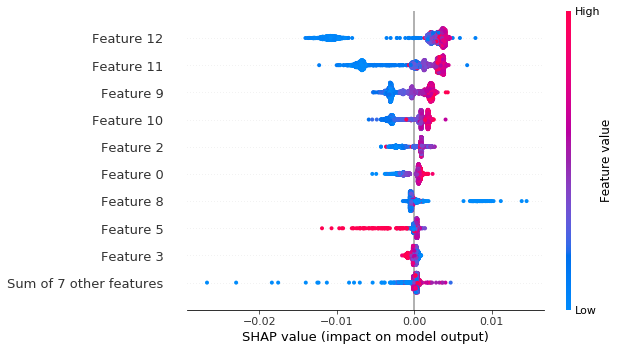

In [62]:
shap.plots.beeswarm(shap_values)

In [ ]:
# use only one vaccine data to test random forest

In [19]:
c1 = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'stay_at_home',
       'mask_mandate',
       'population_density',
       'business_open_0',
       'business_open_1', 'business_open_2']

c2 = [ 'daily_vaccinations_per_million_lag7',
       'daily_vaccinations_per_million_lag14',
       'people_fully_vaccinated_per_hundred_lag7',
       'people_fully_vaccinated_per_hundred_lag14']

In [20]:
grid = {'n_estimators': range(400, 2001, 400),
               'max_features': ['auto', 'sqrt'],
               'max_depth': range(2, 7),
               'min_samples_leaf': [1, 2, 4]}

In [23]:
for col in c2:
    print(col, ":")
    cols = c1 + [col]
    X = data_without_na[cols]
    X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.2, random_state=42)
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -2)
    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    model = rf_random.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(r2_score(y_test, y_pred))

daily_vaccinations_per_million_lag7 :
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 400, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 4}
0.03380849965370358
daily_vaccinations_per_million_lag14 :
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 800, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4}
0.038279826487568225
people_fully_vaccinated_per_hundred_lag7 :
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 1200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4}
0.03571118370728599
people_fully_vaccinated_per_hundred_lag14 :
Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 800, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4}
0.031654078734975166


In [24]:
best_model = RandomForestRegressor(n_estimators = 800, min_samples_leaf = 1, max_features='sqrt', max_depth=4, random_state = 42)

In [35]:
cols = c1 + ['daily_vaccinations_per_million_lag14']
X = data_without_na[cols]
X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.2, random_state=42)

In [36]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2_score(y_test, y_pred)

0.03673900909941652

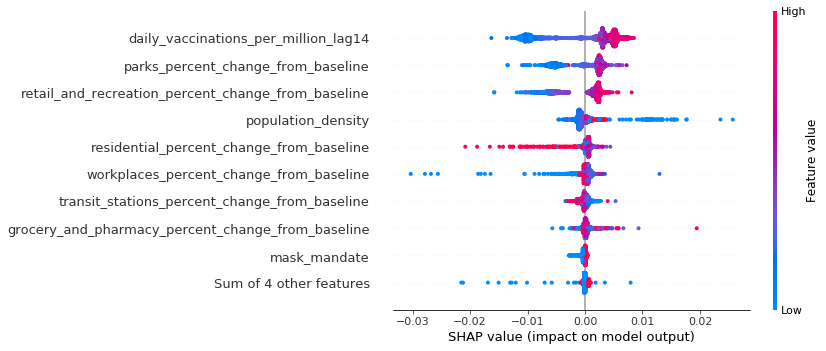

In [37]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

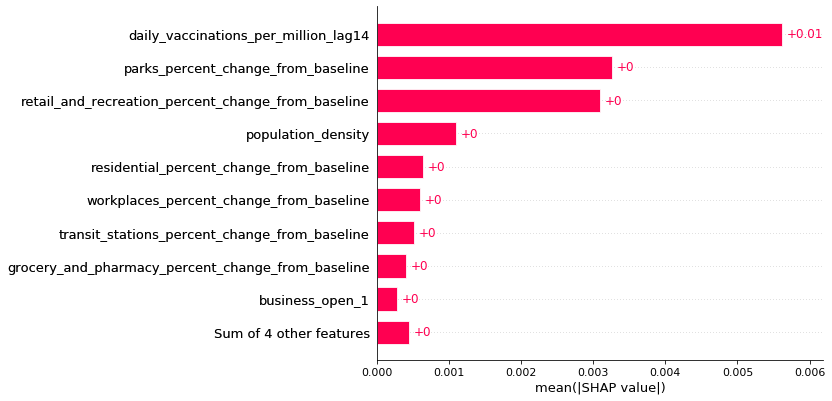

In [38]:
shap.plots.bar(shap_values)

### K-neighbors regression

RandomForestRegressor(max_depth=3, max_features='sqrt', n_estimators=2000)

### SVM

In [64]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Normalize and split data

In [65]:
scaler = RobustScaler() 
X_scaled = scaler.fit_transform(X)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y2, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [67]:
X_train.shape

(2307, 16)

In [68]:
y_train.shape

(2307,)

### simple OLS

In [69]:
model = sm.OLS(y_train, X_train)
results = model.fit()

In [70]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.053
Model:                            OLS   Adj. R-squared (uncentered):              0.046
Method:                 Least Squares   F-statistic:                              8.467
Date:                Mon, 26 Apr 2021   Prob (F-statistic):                    3.21e-19
Time:                        00:10:50   Log-Likelihood:                          2854.4
No. Observations:                2307   AIC:                                     -5679.
Df Residuals:                    2292   BIC:                                     -5593.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [71]:
y_pred = results.predict(X_val)

In [72]:
r2_score(y_val, y_pred)

0.04170868841729303

The performance is pretty bad. According to the p-value, we decide to exclude parameters with bad p-values first.

### PCA

In [73]:
from sklearn.decomposition import PCA

In [74]:
pca = PCA(n_components=3)
pca_covid = pca.fit_transform(X_scaled)